In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve


from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")

HeartDisease is the target column

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.isnull().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

One hot encode categorical variables.

HeartDisease

Smoking

AlcoholDrinking

Stroke

DiffWalking

Sex

AgeCategory

Race

Diabetic

PhysicalActivity

GenHealth

Asthma

KidneyDisease

SkinCancer

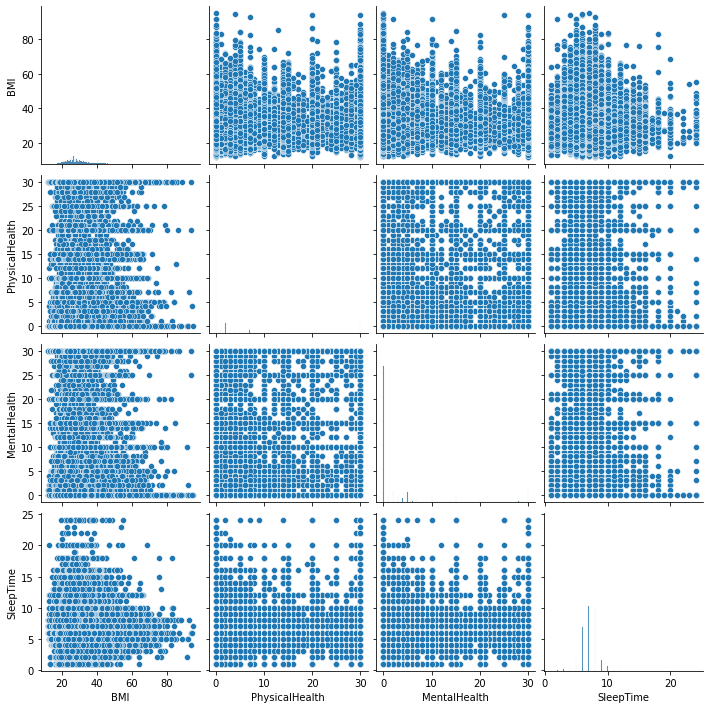

In [5]:
sns.pairplot(df)
plt.show()

First dealing with yes/no

In [6]:
label_encoder = preprocessing.LabelEncoder()
df = pd.get_dummies(df, columns=['Sex', 'Race', 'Diabetic'])

In columns "GenHealth" and "AgeCategory" I am using manual encoding.

In [7]:
df['GenHealth'] = df.GenHealth.map({
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
})

In [8]:
df['AgeCategory'] = df.AgeCategory.map({
    '18-24': 1,
    '25-29': 2,
    '30-34': 3,
    '35-39': 4,
    '40-44': 5,
    '45-49': 6,
    '50-54': 7,
    '55-59': 8,
    '60-64': 9,
    '65-69': 10,
    '70-74': 11,
    '75-79': 12,
    '80 or older': 13
})

In [9]:
df = df.replace({"No": 0, "Yes": 1})

In [10]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,PhysicalActivity,...,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,16.60,1,0,0,3.0,30.0,0,8,1,...,0,0,0,0,0,1,0,0,1,0
1,0,20.34,0,0,1,0.0,0.0,0,13,1,...,0,0,0,0,0,1,1,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,10,1,...,0,0,0,0,0,1,0,0,1,0
3,0,24.21,0,0,0,0.0,0.0,0,12,0,...,0,0,0,0,0,1,1,0,0,0
4,0,23.71,0,0,0,28.0,0.0,1,5,1,...,0,0,0,0,0,1,1,0,0,0


# BMI

(0.0, 60.0)

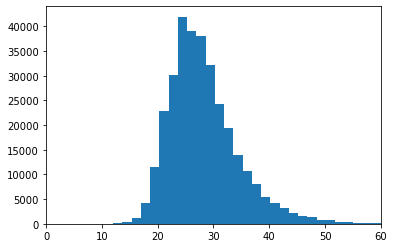

In [11]:
plt.hist(df['BMI'],bins = 50);
plt.xlim(0,60)

This looks like negative binomial distribution. Log it.

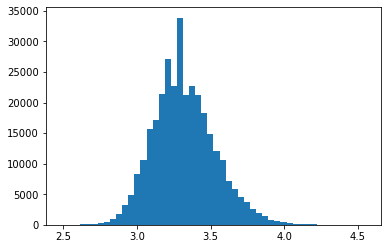

In [12]:
plt.hist(np.log(df['BMI']),bins = 50);
df['BMI'] = np.log(df['BMI'])

# Mental Health
Thinking about your mental health, for how many days during the past 30 days was your mental health not good? 

(0.0, 30.0)

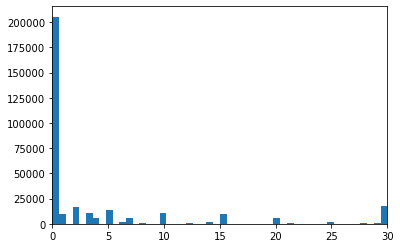

In [13]:
plt.hist(df['MentalHealth'],bins = 50);
plt.xlim(0,30)

Bimodal distribution?

# SleepTime

(0.0, 30.0)

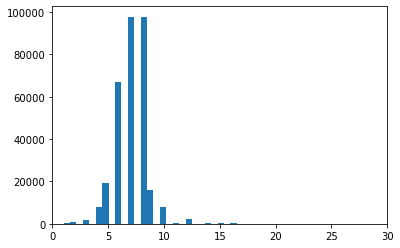

In [14]:
plt.hist(df['SleepTime'],bins = 40);
plt.xlim(0,30)

This one looks ok.

# PhysicalHealth

(0.0, 30.0)

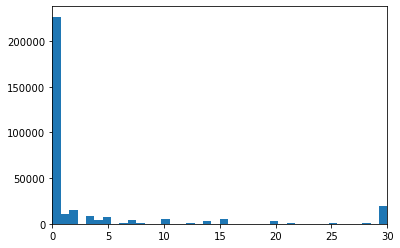

In [15]:
plt.hist(df['PhysicalHealth'],bins = 40);
plt.xlim(0,30)

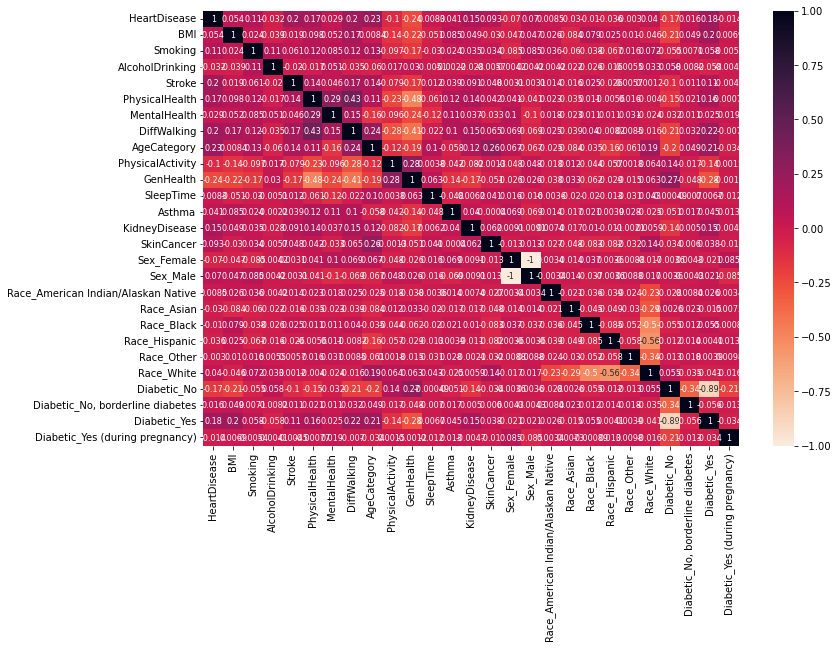

In [16]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), annot = True, cmap= 'rocket_r', annot_kws={"size":8})
plt.show()

Looks similar to MentalHealth column.

In [17]:
training_data = df.sample(frac=0.95, random_state=0)
testing_data = df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 303805
No. of testing examples: 15990


In [18]:
Y_train = training_data.pop('HeartDisease')
X_train = training_data

Y_test = testing_data.pop('HeartDisease')
X_test = testing_data

The dataset have class imbalance. Oversampling the training set using SMOTE.

In [19]:
Y_train.value_counts()

0    277766
1     26039
Name: HeartDisease, dtype: int64

In [20]:
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

In [21]:
col_names = ['BMI','MentalHealth','PhysicalHealth','SleepTime','GenHealth', 'AgeCategory']
features = X_train[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_train[col_names] = features

features = X_test[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_test[col_names] = features

In [22]:
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, Y_train)

In [23]:
Y_pred = clf.predict(X_test)

In [24]:
cf_matrix = confusion_matrix(Y_test, Y_pred)

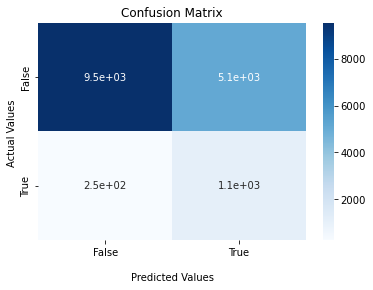

In [25]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
print(metrics.confusion_matrix(Y_test,Y_pred))
print(metrics.classification_report(Y_test, Y_pred))

[[9542 5114]
 [ 247 1087]]
              precision    recall  f1-score   support

           0       0.97      0.65      0.78     14656
           1       0.18      0.81      0.29      1334

    accuracy                           0.66     15990
   macro avg       0.58      0.73      0.53     15990
weighted avg       0.91      0.66      0.74     15990



<Figure size 576x432 with 0 Axes>

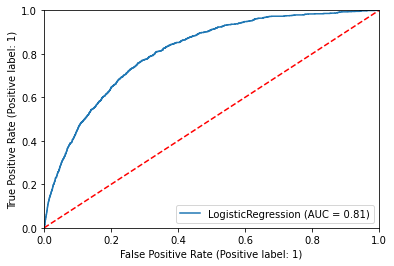

In [27]:
plt.figure(figsize=(8, 6))
svc_disp = RocCurveDisplay.from_estimator(clf, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [41]:

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):

    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



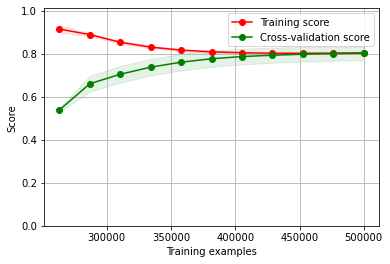

In [42]:
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
plt = plot_learning_curve(clf, X_train, Y_train, cv=10, ylim=(0.0, 1.01), n_jobs=1)
plt.show()